# **Walmart Sales Analysis&Forecasting**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


### **Load The Data**

In [ ]:
from google.colab import files
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

In [ ]:
print(train.head())
print(features.head())
print(stores.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

### **Transforme Date Type**

In [ ]:
train["Date"] = pd.to_datetime(train["Date"], infer_datetime_format=True, errors="coerce")
features["Date"] = pd.to_datetime(features["Date"], infer_datetime_format=True, errors="coerce")

print(train["Date"].head())
print(features["Date"].head())


0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
Name: Date, dtype: datetime64[ns]
0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
Name: Date, dtype: datetime64[ns]


/tmp/ipython-input-654740325.py:1: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/tmp/ipython-input-654740325.py:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



### **Merge DataSets**

In [ ]:
df = train.merge(stores, on="Store", how="left")
df = df.merge(features, on=["Store","Date","IsHoliday"], how="left")

# **📊 Analysis & Visualization**



### **Total sales over time**

In [ ]:
sales_over_time = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
fig1 = px.line(sales_over_time, x="Date", y="Weekly_Sales",
               title="Total Weekly Sales Over Time")
fig1.show()

### **Moving Average**

In [ ]:
import plotly.graph_objects as go
sales_over_time["MA_20"] = sales_over_time["Weekly_Sales"].rolling(window=24).mean()
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=sales_over_time["Date"], y=sales_over_time["Weekly_Sales"],
                          mode="lines", name="Original"))
fig2.add_trace(go.Scatter(x=sales_over_time["Date"], y=sales_over_time["MA_20"],
                          mode="lines", name="20-week MA", line=dict(color="red")))
fig2.update_layout(title="Sales Trend with Moving Average")
fig2.show()


### **The Impact of Holidays**

/tmp/ipython-input-425047100.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




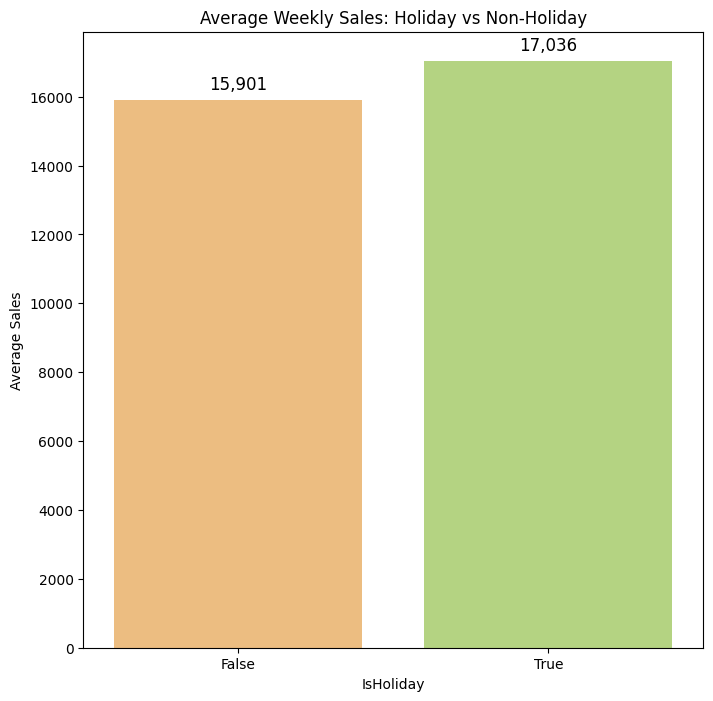

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

holiday_sales = df.groupby("IsHoliday")["Weekly_Sales"].mean().reset_index()
plt.figure(figsize=(8,8))
ax = sns.barplot(x="IsHoliday", y="Weekly_Sales", data=holiday_sales, palette="RdYlGn")

for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0,5),
                textcoords='offset points')

plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Sales")
plt.show()

### **Breakdown by Store Type**

In [ ]:
store_type_sales = df.groupby(["Type","Date"])["Weekly_Sales"].sum().reset_index()
fig4 = px.line(store_type_sales, x="Date", y="Weekly_Sales", color="Type",
               title="Sales Trend by Store Type")
fig4.show()

### **Sales Trend by Store Size**

In [ ]:
df["Size_Group"] = pd.cut(df["Size"],
                          bins=[0, 50000, 150000, 250000],
                          labels=["Small", "Medium", "Large"])
avg_sales = df.groupby("Size_Group")["Weekly_Sales"].mean().reset_index()
fig_bar = px.bar(avg_sales, x="Size_Group", y="Weekly_Sales",
                 title="Average Weekly Sales by Store Size Group",
                 color="Size_Group",
                 text="Weekly_Sales")
fig_bar.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_bar.show()


/tmp/ipython-input-1596290768.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
import plotly.express as px
size_sales = df.groupby(["Date", "Size_Group"])["Weekly_Sales"].sum().reset_index()
fig_area = px.area(size_sales,
                   x="Date",
                   y="Weekly_Sales",
                   color="Size_Group",
                   title="Stacked Sales Trend by Store Size")
fig_area.show()


/tmp/ipython-input-1980043877.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### **Simple Forecasting**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sales_over_time["Date"] = pd.to_datetime(sales_over_time["Date"])
ts = sales_over_time.set_index("Date")["Weekly_Sales"]
ts = ts.resample("W").sum()
model = ExponentialSmoothing(ts, trend="add", seasonal=None)
fit = model.fit()

forecast = fit.forecast(50)
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=ts.index, y=ts.values,mode="lines", name="Actual"))
fig6.add_trace(go.Scatter(x=forecast.index, y=forecast.values,mode="lines", name="Forecast", line=dict(color="red")))
fig6.update_layout(title="Sales Forecast (Exponential Smoothing)")
fig6.show()


In [ ]:
sales_over_time = df.groupby("Date")["Weekly_Sales"].sum().reset_index()
sales_over_time["RollingMean_24"] = sales_over_time["Weekly_Sales"].rolling(window=24).mean()
sales_over_time["EWMA_0.2"] = sales_over_time["Weekly_Sales"].ewm(alpha=0.2, adjust=False).mean()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_over_time["Date"], y=sales_over_time["Weekly_Sales"],mode="lines", name="Original Sales"))
fig.add_trace(go.Scatter(x=sales_over_time["Date"], y=sales_over_time["RollingMean_24"],mode="lines", name="Rolling Mean (24 weeks)"))
fig.add_trace(go.Scatter(x=sales_over_time["Date"], y=sales_over_time["EWMA_0.2"],mode="lines", name="EWMA (α=0.2)"))
fig.update_layout(title="Sales Forecasting (Rolling Mean & Exponential Smoothing)",xaxis_title="Date", yaxis_title="Weekly Sales")
fig.show()
